In [1]:
import matplotlib.pyplot as plt
import numpy as np
import simulations as nb
from scipy.optimize import least_squares

from src import timescale_utils, acf_utils, plts

# set notebook defaults
np.set_printoptions(precision=2)
%load_ext autoreload
%autoreload 2

**simulations of AR(1), AR(2), and fMRI-derived processes**

In [2]:
def get_nls_params(coeffs, coeff_type, n_timepoints):
    """return theoretical nls phi parameters"""

    if coeff_type == "ar_coeffs":
        coeffs = acf_utils.ar_to_acf(coeffs, n_lags=n_timepoints)
    elif coeff_type != "acf":
        raise ValueError("coeff_type in 'ar_coeffs' or 'acf'")

    ks = np.arange(len(coeffs))
    func = lambda phi, k, coeffs: (coeffs - phi**k)
    nls_fit = least_squares(fun=func, args=(ks, coeffs), x0=0, bounds=(-1, +1), ftol=1e-6)
    return nls_fit.x[0]


# set fixed parameters #
n_timepoints, n_repeats = 4800, 1000

# AR(1) #
ar1_sim_phis = np.linspace(0.1, 0.8, 5)
ar1_ols_phis = ar1_sim_phis
ar1_ols_taus = -1 / np.log(ar1_ols_phis)
ar1_nls_phis = ar1_ols_phis
ar1_nls_taus = ar1_ols_taus

# AR(2) #
ar2_sim_phis = np.array(
    [[0.091, 0.09], [0.229, 0.182], [0.347, 0.229], [0.471, 0.24], [0.646, 0.193]]
)  # see AR(2) triangle
ar2_ols_phis = ar1_ols_phis
ar2_ols_taus = ar1_ols_taus
ar2_nls_phis = np.array(
    [get_nls_params(ar_coeff, "ar_coeffs", n_timepoints) for ar_coeff in ar2_sim_phis]
)
ar2_nls_taus = -1 / np.log(ar2_nls_phis)

# HCP #
acf = acf_utils.ACF()
X_hcp = (
    np.load("./data/nsubjects-10_nregions-300_hcp.npy")
    .astype(np.float32)[1, :, [142, 125, 136, 6, 11]]  # phi in {0.1, 0.28, 0.45, 0.62, 0.8}
    .T
)
acfs_ = acf.fit_transform(X_hcp, X_hcp.shape[0])
zero_idx = np.argmax(acfs_ <= 0, axis=0)
mask = np.arange(len(acfs_)).reshape(-1, 1) >= zero_idx
acfs_[mask] = 0  # set \rho_k to zero after k where \rho_k=0
acm_ = acf_utils.acf_to_toeplitz(acfs_, len(acfs_))

hcp_ols_phis = ar1_ols_phis
hcp_ols_taus = ar1_ols_taus
hcp_nls_phis = np.array([get_nls_params(acf_, "acf", n_timepoints) for acf_ in acfs_.T])
hcp_nls_taus = -1 / np.log(hcp_nls_phis)

In [3]:
# !! 25sec runtime !!

# initialize estimators
n_timepoints, acf_n_lags, n_jobs, rs = 4800, 48, -2, 6
var_n_lags = int(0.75 * n_timepoints ** (1 / 3))  # (Stock and Watson, 2015)
estimators = {
    "ols_nr": timescale_utils.OLS(var_estimator="non-robust", n_jobs=n_jobs),
    "ols_nw": timescale_utils.OLS(var_estimator="newey-west", var_n_lags=var_n_lags, n_jobs=n_jobs),
    "nls_nr": timescale_utils.NLS(var_estimator="non-robust", acf_n_lags=acf_n_lags, n_jobs=n_jobs),
    "nls_nw": timescale_utils.NLS(
        var_estimator="newey-west", var_n_lags=acf_n_lags, acf_n_lags=acf_n_lags, n_jobs=n_jobs
    ),
}

# AR(1) #
ar1_estimates_ = nb.mc_simulation(ar1_sim_phis, n_timepoints, estimators, random_seed=rs)

# AR(2) #
ar2_estimates_ = nb.mc_simulation(ar2_sim_phis, n_timepoints, estimators, random_seed=rs)

# HCP #
hcp_estimates_ = nb.mc_simulation(ar1_sim_phis, n_timepoints, estimators, acm=acm_, random_seed=rs)

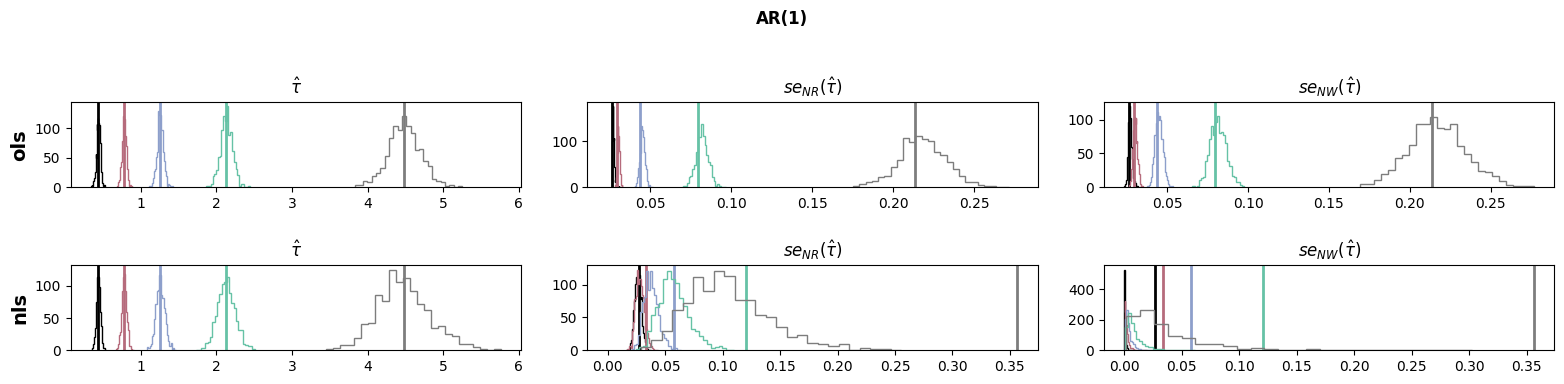

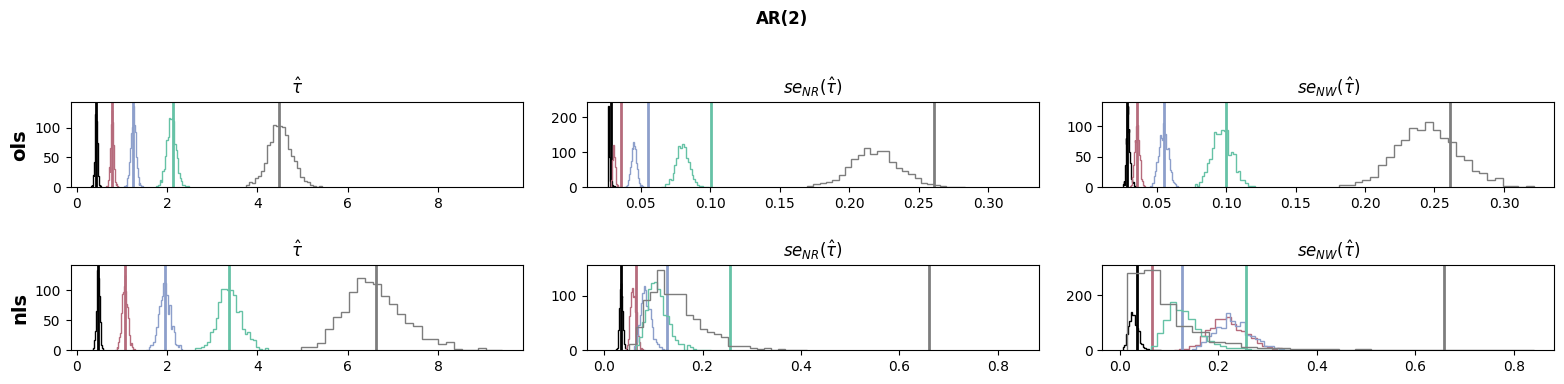

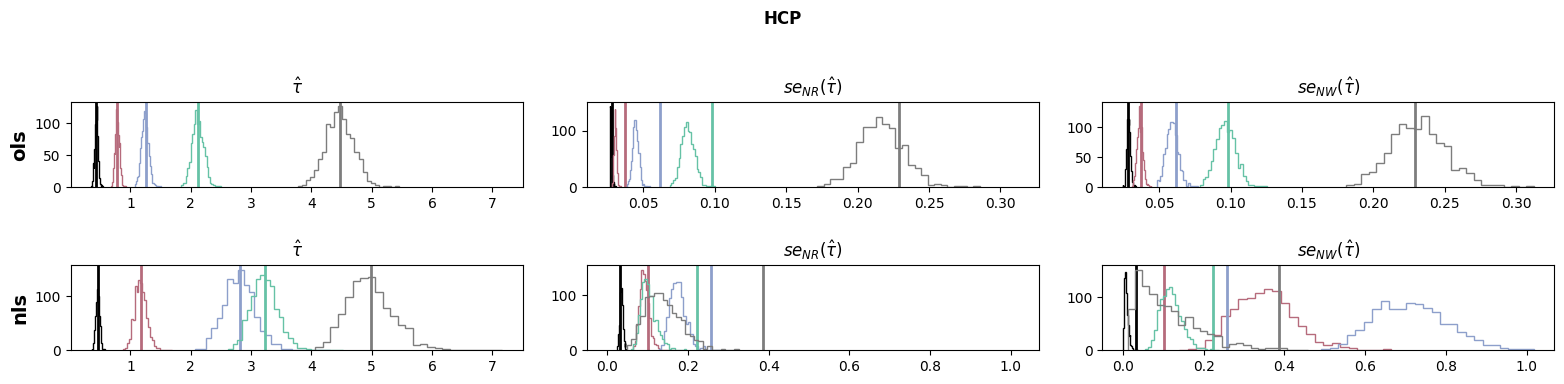

In [4]:
nb.plot_simulation(ar1_estimates_, "tau", ar1_ols_taus, ar1_nls_taus, fig_title="AR(1)")
nb.plot_simulation(ar2_estimates_, "tau", ar2_ols_taus, ar2_nls_taus, fig_title="AR(2)")
nb.plot_simulation(hcp_estimates_, "tau", hcp_ols_taus, hcp_nls_taus, fig_title="HCP")

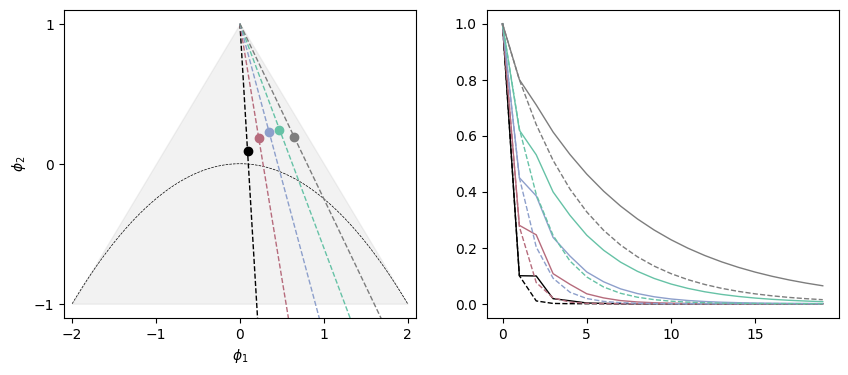

In [5]:
n_lags = 20
colors = ["#000000", "#B66B7C", "#8D9FCB", "#66C2A6", "#7D7D7D"]

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
plts.plot_stationarity_triangle(axs[0], fill_alpha=0.1, annotate=False)
for idx in range(5):
    # AR(2) triangle
    phi1 = np.linspace(0, 2, 100)
    phi2 = 1 - phi1 / ar1_ols_phis[idx]
    axs[0].plot(phi1, phi2, c=colors[idx], ls="--", lw=1)
    axs[0].scatter(ar2_sim_phis[idx, 0], ar2_sim_phis[idx, 1], c=colors[idx])

    # AR(2) acf
    ar1_acf = acf_utils.ar_to_acf(ar1_sim_phis[idx], n_lags=n_lags)
    ar2_acf = acf_utils.ar_to_acf(ar2_sim_phis[idx, :], n_lags=n_lags)
    axs[1].plot(ar1_acf, c=colors[idx], lw=1, ls="--")
    axs[1].plot(ar2_acf, c=colors[idx], lw=1)

### NLS Standard Error Estimation

model: $\rho_k = m(k, \phi) =  \phi^k$  
linearized regressor: $m_{\phi k} = \frac{d}{d\phi} m(k, \phi) = k \phi^{k-1}$  
estimate of linearized regressor: $\hat m_{\phi k} = m_{\phi k}(k, \hat\phi) = k \hat\phi^{k-1}$

**variance estimation**  
errors: $\hat e_k = \rho_k - m(k, \hat\phi)$

1) iid errors 
\begin{align}
se_{iid}(\hat \phi) &= \sqrt{\frac{1}{K} \hat q^{-1} \hat\sigma^2}\\
\hat q &= \frac{1}{K} \sum_{k=0}^{K-1} \hat m_{\phi k}^2 = \frac{1}{K} \sum_{k=0}^{K-1} (k \hat\phi^{k-1})^2\\
\hat \sigma^2 &= \frac{1}{K} \sum_{k=0}^{K-1} \hat e_k^2
\end{align}

2) ind errors 
\begin{align}
se_{ind}(\hat \phi) &= \sqrt{\frac{1}{K} \hat q^{-1} \hat\omega \hat q^{-1}}\\
\hat q &= \frac{1}{K} \sum_{k=0}^{K-1} \hat m_{\phi k}^2 = \frac{1}{K} \sum_{k=0}^{K-1} (k \hat\phi^{k-1})^2\\
\hat \omega &= \frac{1}{K} \sum_{k=0}^{K-1} \hat m_{\phi k}^2 \hat e_k^2
\end{align}

3) nid errors
\begin{align}
se_{nid}(\hat \phi) &= \sqrt{\frac{1}{K} \hat q^{-1} \hat\omega \hat q^{-1}}\\
\hat q &= \frac{1}{K} \sum_{k=0}^{K-1} \hat m_{\phi k}^2 = \frac{1}{K} \sum_{k=0}^{K-1} (k \hat\phi^{k-1})^2\\
\hat \omega &= \sum_{\ell = -M}^M w_{|\ell|} \frac{1}{K} \sum_{1\le k-\ell \le K} (\hat m_{\phi k-\ell} \hat e_{k-\ell}) (\hat m_{\phi k} \hat e_k)
\end{align}

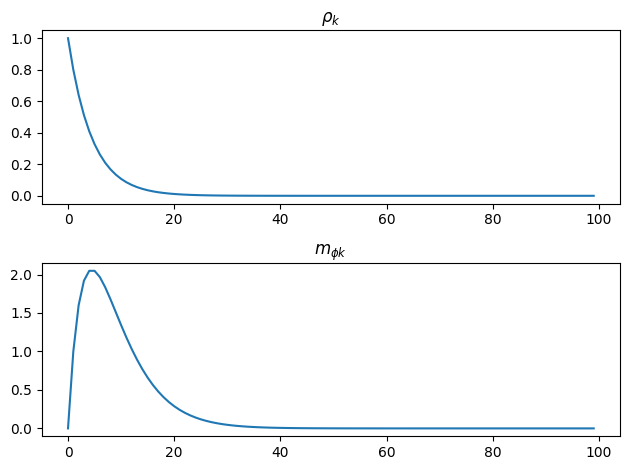

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.sandwich_covariance as sw_cov
from scipy.optimize import curve_fit

phi, n_acf, n_sims = 0.8, 100, 10000
rng = np.random.default_rng(seed=5)
ks = np.arange(n_acf)

m = lambda ks, phi: phi**ks

fig, axs = plt.subplots(nrows=2)
axs[0].set_title(r"$\rho_k$")
axs[0].plot(phi**ks)
axs[1].set_title(r"$m_{\phi k}$")
axs[1].plot(ks * phi ** (ks - 1))
fig.tight_layout()

In [7]:
phis_, scipy_se_, iid_se_, ind_se_, nid_se_ = (
    np.zeros(n_sims),
    np.zeros(n_sims),
    np.zeros(n_sims),
    np.zeros(n_sims),
    np.zeros(n_sims),
)
for idx in range(n_sims):
    acf = phi**ks + rng.normal(size=n_acf, scale=0.05)
    phi_, var_phi_ = curve_fit(m, ks, acf, p0=0, bounds=(-1, +1))
    phi_, var_phi_ = phi_.squeeze(), var_phi_.squeeze()
    phis_[idx] = phi_
    scipy_se_[idx] = np.sqrt(var_phi_)

    # standard errors
    dm_dphi = ks * phi_ ** (ks - 1)
    q_ = np.mean(dm_dphi**2)
    e_ = acf - phi_**ks

    # iid errors
    sigma2_ = np.mean(e_**2)
    var_ = (1 / q_) * sigma2_
    iid_se_[idx] = np.sqrt((1 / n_acf) * var_)

    # ind errors
    omega_ = np.mean(dm_dphi**2 * e_**2)
    var_ = (1 / q_) * omega_ * (1 / q_)
    ind_se_[idx] = np.sqrt((1 / n_acf) * var_)

    # nid errors
    u_ = dm_dphi * (e_**2)
    omega_ = sw_cov.S_hac_simple(u_, weights_func=sw_cov.weights_bartlett).squeeze()
    var_ = (1 / q_) * omega_ * (1 / q_)
    nid_se_[idx] = np.sqrt((1 / n_acf) * var_)

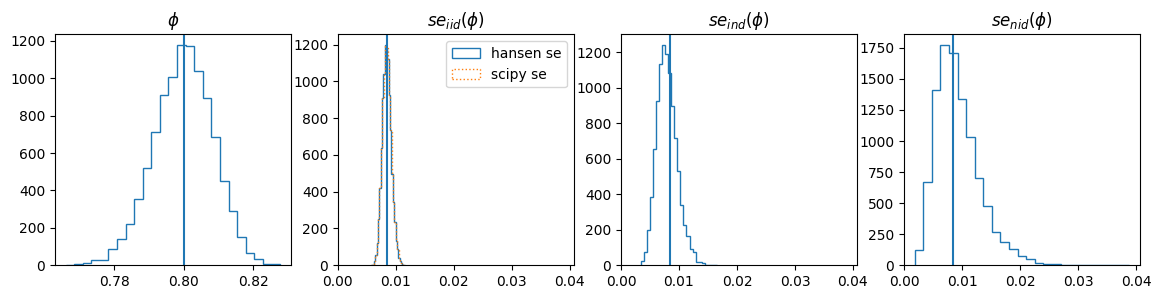

In [8]:
fig, axs = plt.subplots(ncols=4, figsize=(14, 3))
hist_kwargs = dict(bins=25, histtype="step", lw=1)

axs[1].sharex(axs[2])
axs[2].sharex(axs[3])

axs[0].set_title(r"$\phi$")
axs[0].hist(phis_, **hist_kwargs)
axs[0].axvline(phi)

axs[1].set_title(r"$se_{iid}(\phi)$")
axs[1].hist(iid_se_, label="hansen se", **hist_kwargs)
axs[1].hist(scipy_se_, ls=":", label="scipy se", **hist_kwargs)
axs[1].axvline(phis_.std())
axs[1].legend()

axs[2].set_title(r"$se_{ind}(\phi)$")
axs[2].hist(ind_se_, **hist_kwargs)
axs[2].axvline(phis_.std())

axs[3].set_title(r"$se_{nid}(\phi)$")
axs[3].hist(nid_se_, **hist_kwargs)
axs[3].axvline(phis_.std())